## Cats and dogs, image classification with a convolutional neural network

In this project we will try to buil an image recgnition model that can distinguish between pictures of dogs and pictures of cats. 

In [1]:
from matplotlib import pyplot as plt
import os
import random

## Data preprocessing

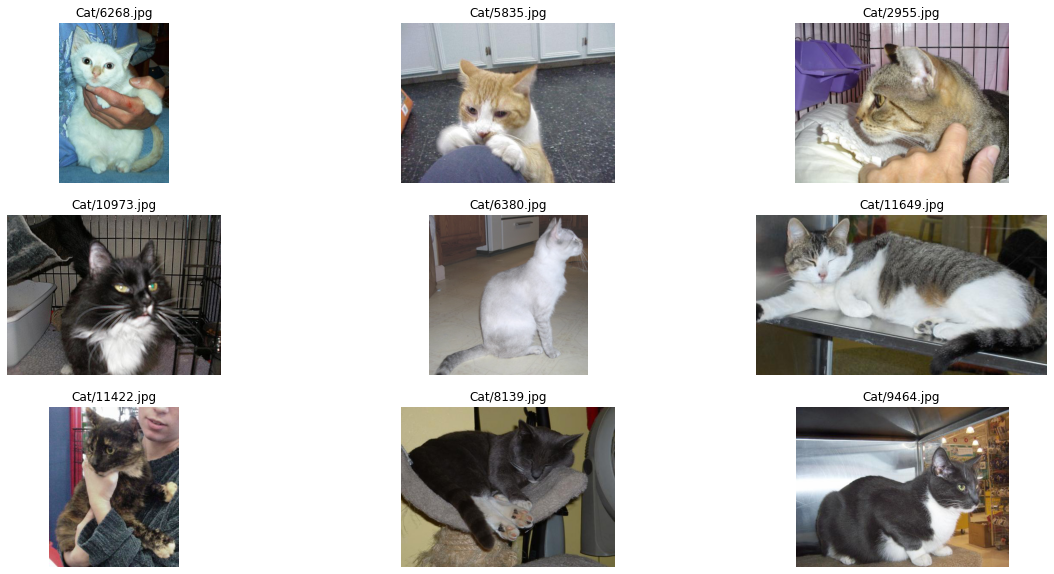

In [2]:
_, _, cat_images = next(os.walk('PetImages/Cat'))

fig, ax = plt.subplots(3,3, figsize=(20,10))

for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('PetImages/Cat/' + img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/' + img)
plt.show()


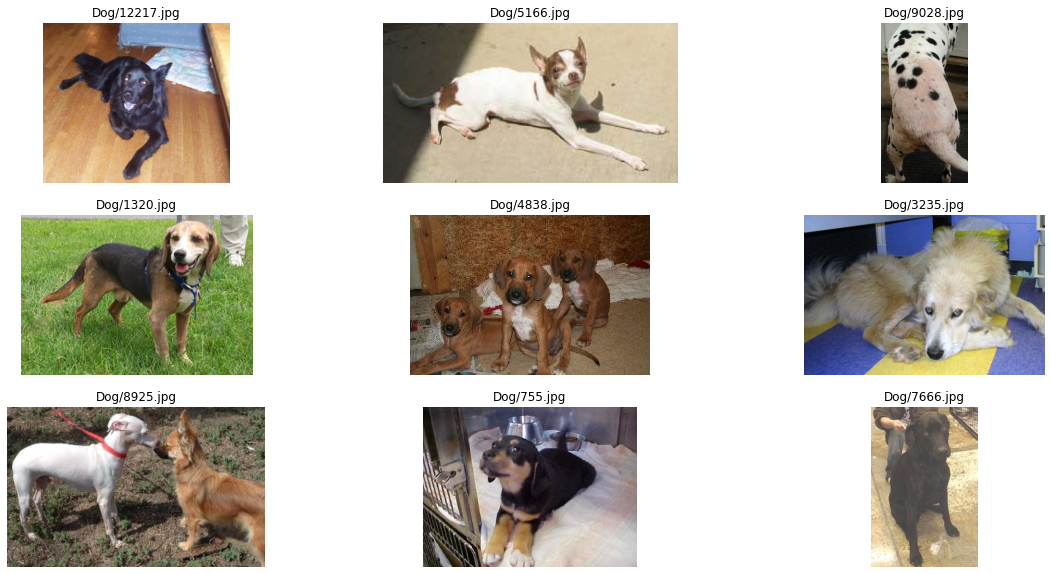

In [3]:
_, _, dog_images = next(os.walk('PetImages/Dog'))

fig, ax = plt.subplots(3,3, figsize=(20,10))

for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread('PetImages/Dog/' + img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Dog/' + img)
plt.show()

In the following cells we will perform image augmentation to enhance our dataset.

In [4]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rotation_range = 30,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                                fill_mode = 'nearest')

12088.jpg


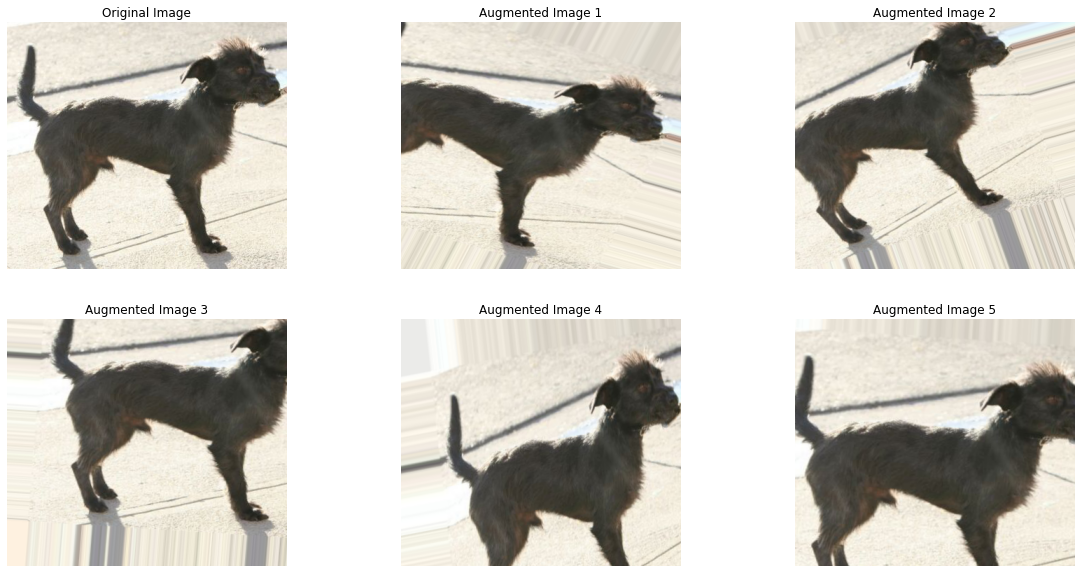

In [5]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
all_images = []

_, _, dog_images = next(os.walk('PetImages/Train/Dog/'))
random_img = random.sample(dog_images, 1)[0]
print(random_img)
random_img = plt.imread('PetImages/Train/Dog/'+random_img)
all_images.append(random_img)

random_img = random_img.reshape((1,) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))

for idx, img in enumerate(all_images):
    ax[int(idx/3), idx%3].imshow(img)
    ax[int(idx/3), idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title('Original Image')
    else:
        ax[int(idx/3), idx%3].set_title('Augmented Image {}'.format(idx))


plt.show()

## Model building

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()

In [7]:
FILTER_SIZE = 3
NUM_FILTERS = 32
INPUT_SIZE  = 32
MAXPOOL_SIZE = 2
BATCH_SIZE = 16
STEPS_PER_EPOCH = 20000//BATCH_SIZE
EPOCHS = 10

model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), input_shape = (INPUT_SIZE, INPUT_SIZE, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), input_shape = (INPUT_SIZE, INPUT_SIZE, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))


In [8]:
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [9]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
training_data_generator = ImageDataGenerator(rescale = 1./255)
training_set = training_data_generator.flow_from_directory('PetImages/Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator.flow_from_directory('PetImages/Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')

model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
1250/1250 [==============================] - 71s 57ms/step - loss: 0.6447 - accuracy: 0.6175
Epoch 2/10
1250/1250 [==============================] - 60s 48ms/step - loss: 0.5462 - accuracy: 0.7249
Epoch 3/10
1250/1250 [==============================] - 58s 47ms/step - loss: 0.4953 - accuracy: 0.7624
Epoch 4/10
1250/1250 [==============================] - 57s 46ms/step - loss: 0.4640 - accuracy: 0.7802
Epoch 5/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4370 - accuracy: 0.7971
Epoch 6/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.4136 - accuracy: 0.8101
Epoch 7/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.3926 - accuracy: 0.8218
Epoch 8/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.3735 - accuracy: 0.8315
Epoch 9

Let's evaluate our model :

In [11]:
score = model.evaluate(test_set, steps=100)

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

100/100 [==============================] - 5s 50ms/step - loss: 0.4394 - accuracy: 0.8037
loss: 0.4393613934516907
accuracy: 0.8037499785423279


## Implemeting VGG 16

Transfer learning means using a model than has been train work a certain task A and modifiying it to use it on task B. Task A and B have ot be similar to do this of course. Here we are going to use the VGG16 than won ILSVR in 2014 !

In [12]:
from keras.applications.vgg16 import VGG16

INPUT_SIZE = 48 
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(INPUT_SIZE,INPUT_SIZE,3))



In [13]:
for layer in vgg16.layers:
    layer.trainable = False

In [24]:
from keras.models import Model

inputs = vgg16.input
outputs = vgg16(input_)
last_layer = Flatten(name='flatten')(outputs)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(inputs=inputs, outputs=last_layer)


In [27]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

training_set = training_data_generator.flow_from_directory('PetImages/Train/',
                                                target_size = (INPUT_SIZE, INPUT_SIZE),
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'binary')

test_set = testing_data_generator.flow_from_directory('PetImages/Test/',
                                             target_size = (INPUT_SIZE, INPUT_SIZE),
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'binary')


model.fit_generator(training_set, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, verbose=1)

Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 298s 1s/step - loss: 0.3654 - accuracy: 0.8413
Epoch 2/3
200/200 [==============================] - 306s 2s/step - loss: 0.2799 - accuracy: 0.8747
Epoch 3/3
200/200 [==============================] - 307s 2s/step - loss: 0.2679 - accuracy: 0.8822


Let's evaluate the model now :

In [29]:
score = model.evaluate(test_set, steps=100)

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

100/100 [==============================] - 168s 2s/step - loss: 0.2794 - accuracy: 0.8794
loss: 0.2793876528739929
accuracy: 0.8793749809265137
